# Extract data for single layers of composite sample for cross reference

In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

## Quartz @ 1040µm 

bias of sample_pulse before 60 ps: -104.37799501233309
Length of ref_df: 991
Length of sample_df: 991


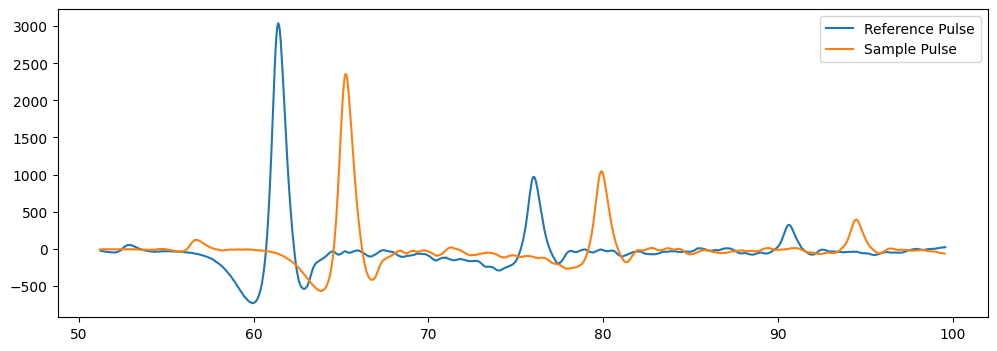

In [2]:
sample_path = 'New_samples_csv/Quartz_1040um_circle_16_01_56.csv'
ref_path = 'New_samples_csv/ref_15_28_05.csv'

ref_df = pd.read_csv(ref_path).dropna()
sample_df = pd.read_csv(sample_path).dropna()

# Remove bias from samples
mask = sample_df['Time_ps'] < 60
bias = np.mean(sample_df['Signal'][mask])
print("bias of sample_pulse before 60 ps:", bias)

ref_df['Signal'] -= bias
sample_df['Signal'] -= bias

# Drop first 1 rows fromref to match lengths
ref_df = ref_df.iloc[2:].reset_index(drop=True)

print("Length of ref_df:", len(ref_df))
print("Length of sample_df:", len(sample_df))

plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'], ref_df['Signal'], label='Reference Pulse')
plt.plot(sample_df['Time_ps'], sample_df['Signal'], label='Sample Pulse')  # Fixed label
plt.legend()
plt.show()

In [3]:
L = len(sample_df['Time_ps'])
n_quartz_1 = 2
n_quartz_2 = 2
n_gaas = 3.4

k_quartz_1 = 0
k_quartz_2 = 0
k_gaas = 0

d_quartz_1 = 1050 * 1e-6 # 1050 um
d_quartz_2 = 1040 * 1e-6 # 1040 um
d_gaas = 490 * 1e-6 # 490 um

deltat = np.diff(ref_df['Time_ps'].to_numpy())[0] # Have checked time steps are uniform
print(f'{deltat} ps')
deltat *= 1e-12

0.048828125 ps


In [4]:
optimize_mask = [
    (True, True, False) 

]

init_guess = [ 
    ((n_quartz_2 + 1j*k_quartz_2), d_quartz_2)
]

# convert pulses to tensors
ref_pulse_t = torch.tensor(ref_df['Signal'].to_numpy(), dtype=torch.float32)
sample_pulse_t = torch.tensor(sample_df['Signal'].to_numpy(), dtype=torch.float32)

print(init_guess)

[((2+0j), 0.00104)]


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.9, 2.1)
Layer 1 - k ∈ (-0.01, 0.01)


/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1, -0.01] before, using random point [1.9039561803404315, -0.002284043538626759]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1, -0.01] before, using random point [2.0319204324428464, 0.006163560675250817]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1, -0.01] before, using random point [1.9585847437004296, -0.005731530027012183]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1, -0.01] before, using random point [1.9162344205170807, -0.00803637493516707]
  warnings.warn(
/opt/anaconda3/envs/mp

Bayes params: [((2.1-0.01j), 0.00104)]


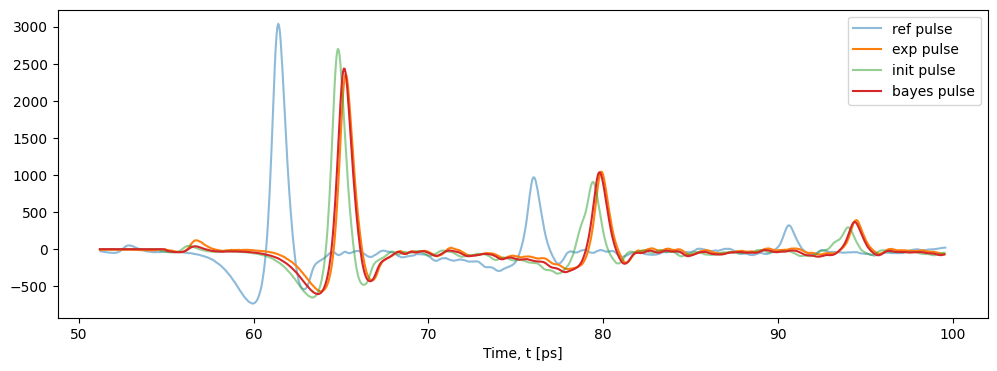

In [5]:
# Simulate pulse with initial guess
init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, 0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess, optimize_mask=optimize_mask)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='exp pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), init_pulse, label='init pulse', alpha = 0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 2 parameters for 100 iterations.
Iteration 9, Loss: 5.381369e+01, Layer 0: n=2.1099, k=-0.01781, D=1040.00 µm
Iteration 19, Loss: 3.675964e+01, Layer 0: n=2.1194, k=-0.01437, D=1040.00 µm
Iteration 29, Loss: 3.051069e+01, Layer 0: n=2.1271, k=-0.01253, D=1040.00 µm
Iteration 39, Loss: 3.120969e+01, Layer 0: n=2.1298, k=-0.01458, D=1040.00 µm
Iteration 49, Loss: 3.065102e+01, Layer 0: n=2.1284, k=-0.01324, D=1040.00 µm
Iteration 59, Loss: 3.034263e+01, Layer 0: n=2.1265, k=-0.01383, D=1040.00 µm
Iteration 69, Loss: 3.038890e+01, Layer 0: n=2.1262, k=-0.01344, D=1040.00 µm
Iteration 79, Loss: 3.033529e+01, Layer 0: n=2.1268, k=-0.01368, D=1040.00 µm
Iteration 89, Loss: 3.033828e+01, Layer 0: n=2.1271, k=-0.01356, D=1040.00 µm
Iteration 99, Loss: 3.033382e+01, Layer 0: n=2.1269, k=-0.01364, D=1040.00 µm
[((2.1267619132995605-0.013734322972595692j), 0.0010400000028312206)]


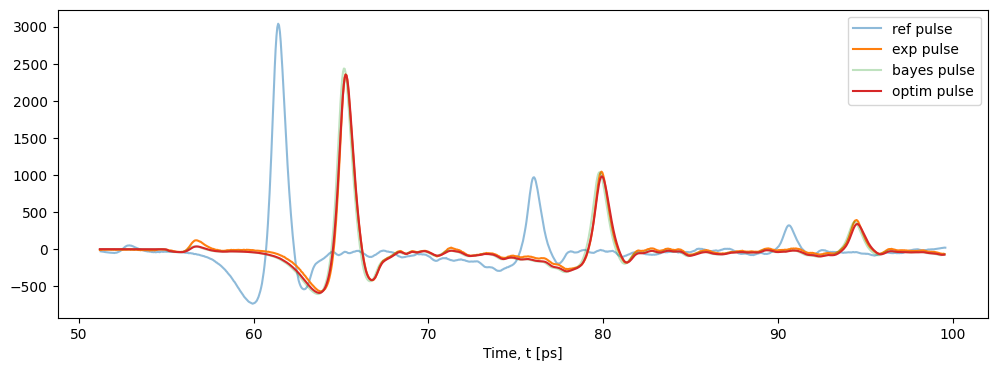

In [6]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.001)
optim_params = grad_optimizer.optimize(num_iterations=100, updates=10, alpha=1)


optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='exp pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), Bayesian_pulse, label='bayes pulse', alpha = 0.3)
plt.plot(sample_df['Time_ps'].to_numpy(), optim_pulse, label='optim pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

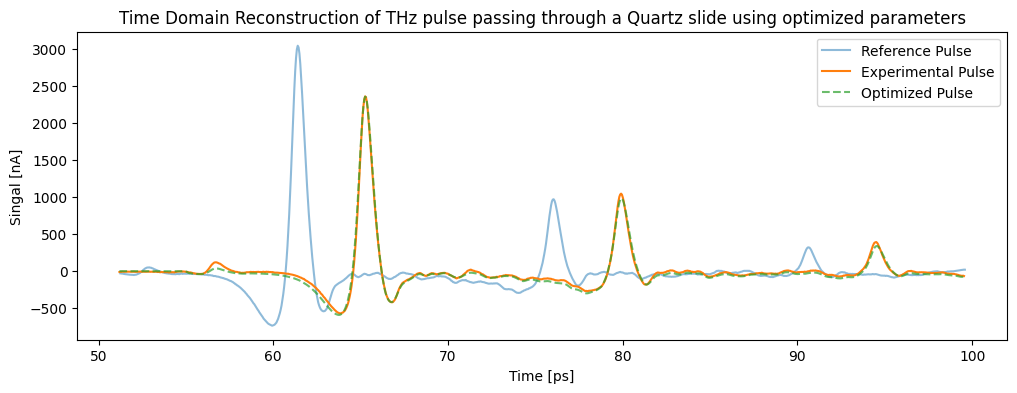

In [9]:
plt.figure(figsize=(12,4))
plt.title('Time Domain Reconstruction of THz pulse passing through a Quartz slide using optimized parameters')
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='Reference Pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='Experimental Pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), optim_pulse, label='Optimized Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Singal [nA]')
plt.legend()
plt.show()

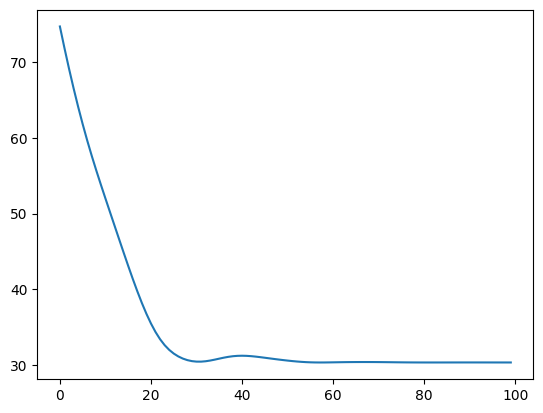

In [7]:
plt.plot(grad_optimizer.loss_history)